# Packages & Libraries

In [ ]:
#Installation of needed libraries such as tsai for e.g. using preprocess and training
!pip install tsai
!pip install fastai
from tsai.all import *

#Sklearn metrices, matplot, numpy, pandas
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
plt.rcParams['font.size'] = 14

%reload_ext autoreload
%autoreload 2
%matplotlib inline
my_setup()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.9/298.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
os              : Linux-5.15.107+-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1+cu118
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [15.0] GB


# Models

In [ ]:
#XCM - Implementation References at the end in the last cell
class XCM(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:Optional[int]=None, nf:int=128, window_perc:float=1., flatten:bool=False, custom_head:callable=None,
                 concat_pool:bool=False, fc_dropout:float=0., bn:bool=False, y_range:tuple=None, **kwargs):

        window_size = int(round(seq_len * window_perc, 0))
        self.conv2dblock = nn.Sequential(*[Unsqueeze(1), Conv2d(1, nf, kernel_size=(1, window_size), padding='same'), BatchNorm(nf), nn.ReLU()])
        self.conv2d1x1block = nn.Sequential(*[nn.Conv2d(nf, 1, kernel_size=1), nn.ReLU(), Squeeze(1)])
        self.conv1dblock = nn.Sequential(*[Conv1d(c_in, nf, kernel_size=window_size, padding='same'), BatchNorm(nf, ndim=1), nn.ReLU()])
        self.conv1d1x1block = nn.Sequential(*[nn.Conv1d(nf, 1, kernel_size=1), nn.ReLU()])
        self.concat = Concat()
        self.conv1d = nn.Sequential(*[Conv1d(c_in + 1, nf, kernel_size=window_size, padding='same'), BatchNorm(nf, ndim=1), nn.ReLU()])

        self.head_nf = nf
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: self.head = custom_head(self.head_nf, c_out, seq_len, **kwargs)
        else: self.head = self.create_head(self.head_nf, c_out, seq_len, flatten=flatten, concat_pool=concat_pool,
                                           fc_dropout=fc_dropout, bn=bn, y_range=y_range)


    def forward(self, x):
        x1 = self.conv2dblock(x)
        x1 = self.conv2d1x1block(x1)
        x2 = self.conv1dblock(x)
        x2 = self.conv1d1x1block(x2)
        out = self.concat((x2, x1))
        out = self.conv1d(out)
        out = self.head(out)
        return out


    def create_head(self, nf, c_out, seq_len=None, flatten=False, concat_pool=False, fc_dropout=0., bn=False, y_range=None):
        if flatten:
            nf *= seq_len
            layers = [Flatten()]
        else:
            if concat_pool: nf *= 2
            layers = [GACP1d(1) if concat_pool else GAP1d(1)]
        layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)


    def show_gradcam(self, x, y=None, detach=True, cpu=True, apply_relu=True, cmap='rainbow', figsize=None, **kwargs):

        att_maps = get_attribution_map(self, [self.conv2dblock, self.conv1dblock], x, y=y, detach=detach, cpu=cpu, apply_relu=apply_relu)
        att_maps[0] = ((att_maps[0] - att_maps[0].min()) / (att_maps[0].max() - att_maps[0].min()))
        att_maps[1] = (att_maps[1] - att_maps[1].min()) / (att_maps[1].max() - att_maps[1].min())

        figsize = ifnone(figsize, (20, 20))
        fig = plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        plt.title('Beobachtete Variable')
        plt.xlabel('Length')
        plt.ylabel('Features')
        im = ax.imshow(att_maps[0], cmap=cmap)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        plt.show()

        fig = plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        plt.title('Zeit')
        plt.xlabel('Length')
        plt.ylabel('Features')
        im = ax.imshow(att_maps[1], cmap=cmap)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        plt.show()

# Dataset

['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']
X      - shape: [360 samples x 24 features x 51 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (360,)  type: memmap  dtype:<U3  n_classes: 6 (60 samples per class) ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']  isnan: False
splits - n_splits: 2 shape: [180, 180]  overlap: False


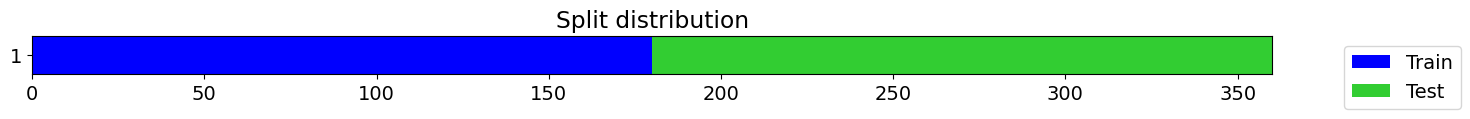

In [ ]:
# Using imported methods for getting UCR data such as the NATOPS dataset, and its splitting into X y
print(get_UCR_multivariate_list())
#Trainingsphase, Testphase, Plot and Prediction (Batch)


dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms = [None, TSCategorize()]

check_data(X,y, splits)

# Checking Data

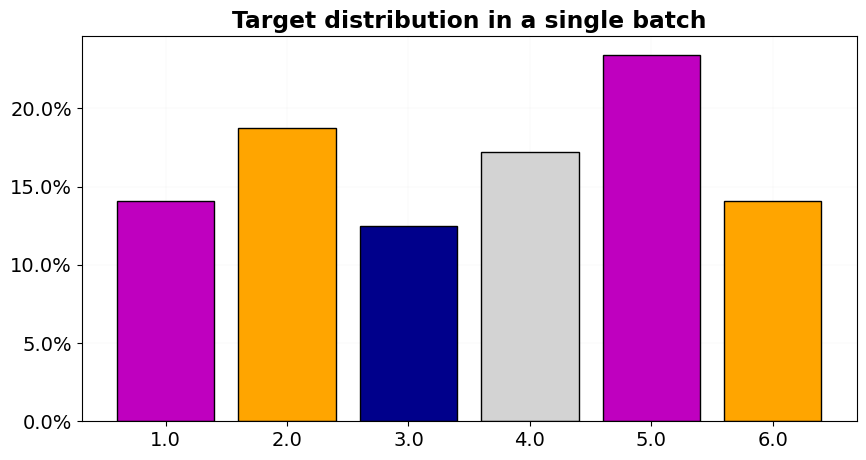

In [ ]:
#Using the dataloader of the library & showing the distribution of data classes in a single batch
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train = True)

dls.show_dist(figsize = (10,5))


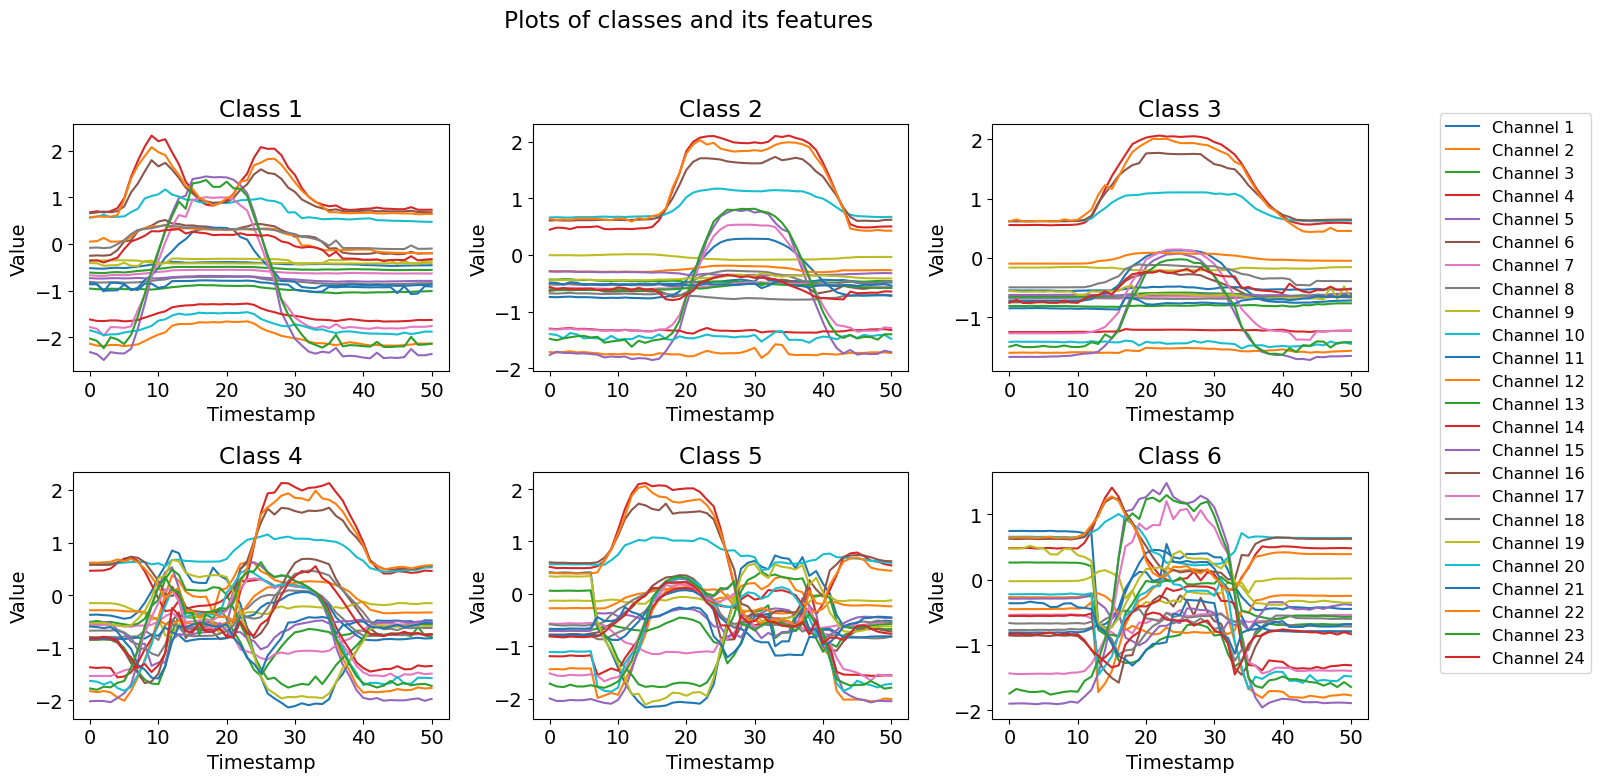

In [ ]:
dataposition_class_samples_1 = []
dataposition_class_samples_2 = []
dataposition_class_samples_3 = []
dataposition_class_samples_4 = []
dataposition_class_samples_5 = []
dataposition_class_samples_6 = []

count_each_sample_label = 0
for each in y:
  if y[count_each_sample_label] == "1.0":
    dataposition_class_samples_1.append(count_each_sample_label)
  if y[count_each_sample_label] == "2.0":
    dataposition_class_samples_2.append(count_each_sample_label)
  if y[count_each_sample_label] == "3.0":
    dataposition_class_samples_3.append(count_each_sample_label)
  if y[count_each_sample_label] == "4.0":
    dataposition_class_samples_4.append(count_each_sample_label)
  if y[count_each_sample_label] == "5.0":
    dataposition_class_samples_5.append(count_each_sample_label)
  if y[count_each_sample_label] == "6.0":
    dataposition_class_samples_6.append(count_each_sample_label)
  count_each_sample_label +=1


dataposition_class_samples = [[] for _ in range(6)]

for i, label in enumerate(y):
    class_index = int(float(label) - 1)
    dataposition_class_samples[class_index].append(i)

class_list = ["1", "2", "3", "4", "5", "6" ]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Plots of classes and its features')


for i, each in enumerate(class_list):
  if each == "1":
    # Convert into TSTensor
    tensor = TSTensor(X[dataposition_class_samples_1[0]])
    class_val = 1
  if each == "2":
    tensor = TSTensor(X[dataposition_class_samples_2[0]])
    class_val = 2
  if each == "3":
    tensor = TSTensor(X[dataposition_class_samples_3[0]])
    class_val = 3
  if each == "4":
    tensor = TSTensor(X[dataposition_class_samples_4[0]])
    class_val = 4
  if each == "5":
    tensor = TSTensor(X[dataposition_class_samples_5[0]])
    class_val = 5
  if each == "6":
    tensor = TSTensor(X[dataposition_class_samples_6[0]])
    class_val = 6

  #Plotten sample for class
  count_each_tensor = 0
  for z in tensor:
    channel = tensor[count_each_tensor]
    channel_np = channel.cpu().numpy()
    row = i // 3
    col = i % 3
    axes[row, col].plot(channel_np, label="Channel " + str(count_each_tensor + 1))
    count_each_tensor += 1

    axes[row, col].set_xlabel('Timestamp')
    axes[row, col].set_ylabel('Value')
    axes[row, col].set_title('Class ' + str(class_val))

# Legend outside
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize='small')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Train XCM Model

In [ ]:
#Getting shape for XCM Models
xb, yb = dls.one_batch()
dls.decode_batch((xb,yb), max_n = len(X))
bs, c_in, seq_len = xb.shape
c_out = len(np.unique(yb.cpu().numpy()))

In [ ]:
#Creating Model with its parameter
model_XCM = XCM(c_in, c_out, seq_len)

#Checking if its fits and device recognition
test_eq(model_XCM.to(xb.device)(xb).shape, (bs, c_out))

#Compilng with learner from library with dataloader and model
learn_XCM = ts_learner(dls, model_XCM, metrics=accuracy)

#Fit with 50 epochs and learnrate 0.0001
learn_XCM.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.834838,1.790325,0.166667,00:00
1,1.802993,1.784871,0.166667,00:00
2,1.771151,1.773212,0.166667,00:00
3,1.727407,1.749816,0.211111,00:00
4,1.671939,1.706098,0.433333,00:00
5,1.610808,1.632600,0.483333,00:00
6,1.538972,1.520695,0.566667,00:00
7,1.459723,1.365141,0.688889,00:00
8,1.381385,1.184786,0.755556,00:00
9,1.310386,1.010535,0.788889,00:00


# Results & Probabilities of XCM

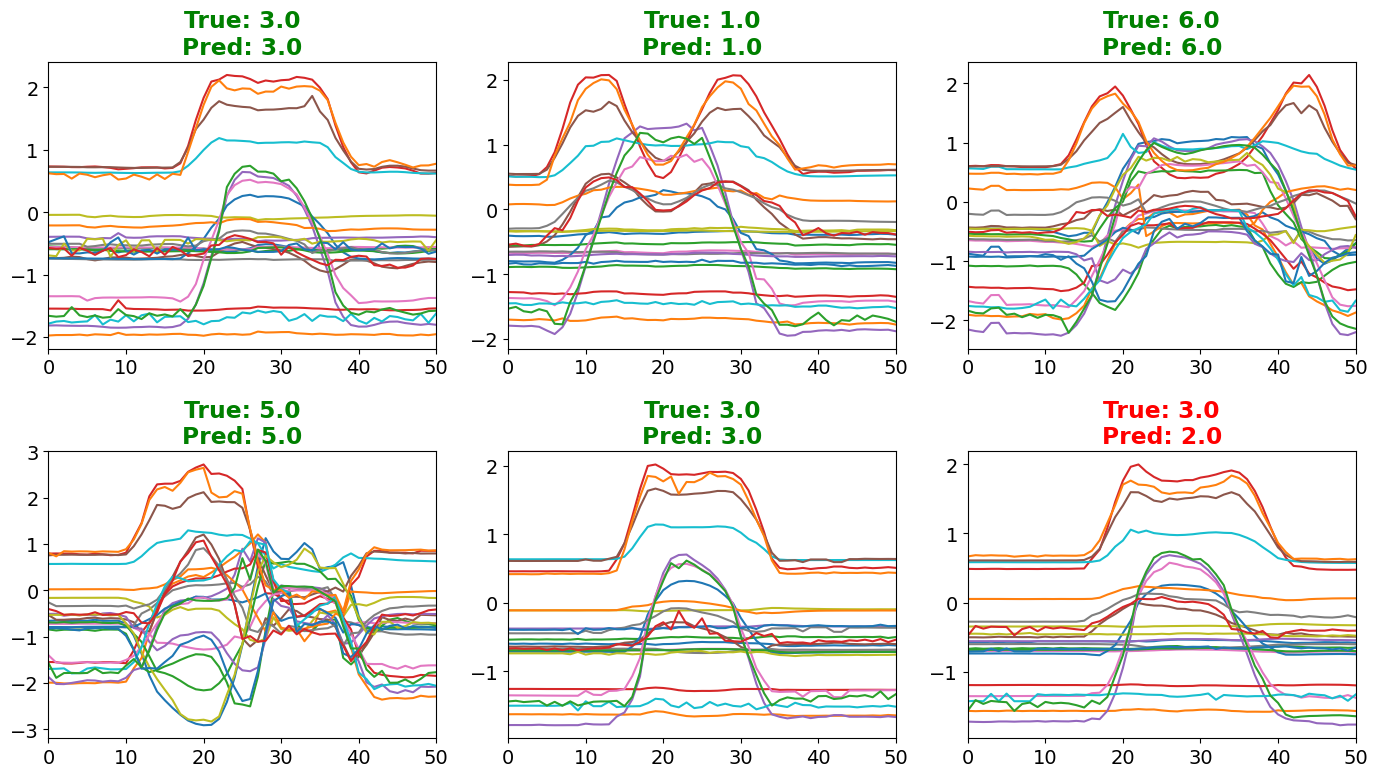

In [ ]:
#Predictions
learn_XCM.show_results(figsize = (14,8), max_n = 6)

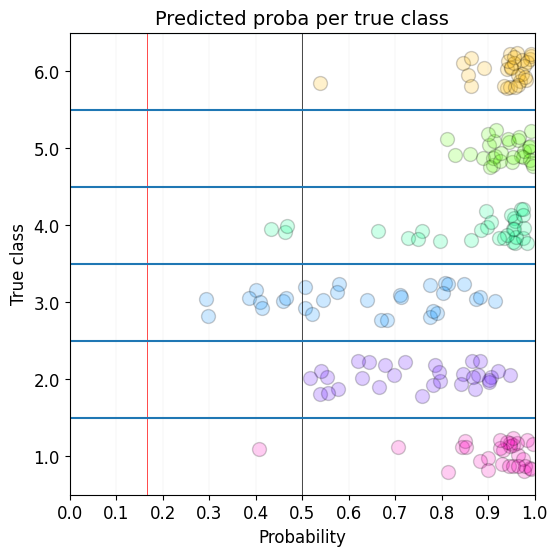

In [ ]:
#Probabilities
learn_XCM.show_probas()


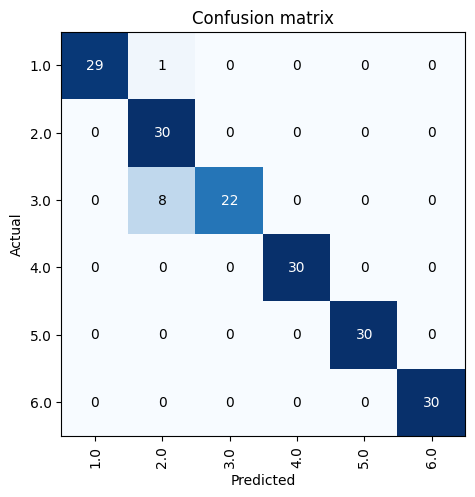

In [ ]:
#Confusion
learn_XCM.plot_confusion_matrix()

# Trained Weights of each Layer of XCM Model

In [ ]:
print("Kurze Beschreibung der Layer inkl.Gewichte zur Orientierung:" )
print(learn_XCM.state_dict().keys())
print(learn_XCM.state_dict().get('conv2dblock.1.conv2d_same.weight')) #Durch .get("Bezeichnung") möglich den jeweiligen Layer mit Gewichten anzeigen zu lassen (Keys)
learn_XCM.save("XCM_Batch") #speichert trainiertes Model
#learn.load('XCM_Batch') #So wird das gespeicherte Modell aufgerufen werden

Kurze Beschreibung der Layer inkl.Gewichte zur Orientierung:
odict_keys(['conv2dblock.1.weight', 'conv2dblock.1.bias', 'conv2dblock.1.conv2d_same.weight', 'conv2dblock.1.conv2d_same.bias', 'conv2dblock.2.weight', 'conv2dblock.2.bias', 'conv2dblock.2.running_mean', 'conv2dblock.2.running_var', 'conv2dblock.2.num_batches_tracked', 'conv2d1x1block.0.weight', 'conv2d1x1block.0.bias', 'conv1dblock.0.weight', 'conv1dblock.0.bias', 'conv1dblock.1.weight', 'conv1dblock.1.bias', 'conv1dblock.1.running_mean', 'conv1dblock.1.running_var', 'conv1dblock.1.num_batches_tracked', 'conv1d1x1block.0.weight', 'conv1d1x1block.0.bias', 'conv1d.0.weight', 'conv1d.0.bias', 'conv1d.1.weight', 'conv1d.1.bias', 'conv1d.1.running_mean', 'conv1d.1.running_var', 'conv1d.1.num_batches_tracked', 'head.1.0.weight', 'head.1.0.bias'])
tensor([[[[-6.3208e-03, -6.0602e-04,  1.1788e-01,  ..., -5.5408e-02,
            1.1038e-02, -5.9764e-02]]],


        [[[-9.9124e-02, -2.5767e-02,  6.2740e-03,  ...,  9.1185e-02,
       

Path('models/XCM_Batch.pth')

In [ ]:
klassen_namen = list(np.unique(dls.decodes(yb)))
klassen_namen[:]

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

# XAI: XCM Model

Getting Predictions for the usage (see below)

In [ ]:
test_dl = dls.valid

input_values = []
label_values = []

for batch in test_dl:
    xb, yb = batch
    input_values.append(xb)
    label_values.append(yb)

input_values = torch.cat(input_values)
label_values = torch.cat(label_values)

_, predictions, labels = learn_XCM.get_preds(dl=test_dl, with_decoded=True)



In [ ]:
input_values

TSTensor(samples:180, vars:24, len:51, device=cuda:0, dtype=torch.float32)

In [ ]:
labels

tensor([3, 4, 5, 0, 3, 2, 1, 2, 1, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
        1, 1, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 3,
        2, 2, 1, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
        0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 1,
        1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 1, 1, 1, 4, 1, 0, 0, 2, 4, 1,
        0, 3, 4, 3, 1, 2, 2, 2, 2, 0, 4, 0, 0, 1, 3, 4, 4, 1, 1, 1, 1, 4, 4, 3,
        1, 4, 0, 4, 5, 5, 1, 5, 3, 3, 5, 5, 4, 3, 5, 1, 3, 1, 3, 0, 1, 3, 0, 2,
        5, 2, 1, 5, 3, 1, 0, 5, 1, 4, 3, 3])

In [ ]:
print("Vorhersagen:")
print(predictions)

print("Labels:")
print(labels)

Vorhersagen:
tensor([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
        1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
        2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
        0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
        1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
        0, 3, 4, 3, 1, 2, 2, 2, 2, 0, 4, 0, 0, 1, 3, 4, 4, 2, 1, 1, 1, 4, 4, 3,
        1, 4, 0, 4, 5, 5, 1, 5, 3, 3, 5, 5, 4, 3, 5, 1, 3, 2, 3, 0, 1, 3, 0, 2,
        5, 2, 1, 5, 3, 1, 0, 5, 2, 4, 3, 3])
Labels:
tensor([3, 4, 5, 0, 3, 2, 1, 2, 1, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
        1, 1, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 3,
        2, 2, 1, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
        0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 1,
        1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 1, 1

# Checking which Data is classificated wrong (XCM)

In [ ]:
list_of_miss_predicted = []
list_of_wrong_classes = []
list_of_true_classes = []
check = 0
while check < len(labels):
  if(labels[check] != predictions[check]):
    print("At datainstance :")
    print(check)
    print("with class ")
    print(labels[check].item() + 1)
    print("the model miss predicted the following class:")
    print(predictions[check].item() + 1)
    print("----------")
    list_of_miss_predicted.append(check)
    list_of_wrong_classes.append(predictions[check].item() + 1)
    list_of_true_classes.append(labels[check].item() + 1)

  check+=1

print("List of miss predicted datainstances :" + str(list_of_miss_predicted))
print("List of wrong classes :" + str(list_of_wrong_classes))
print("List of true classes :" + str(list_of_true_classes))

At datainstance :
8
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
25
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
41
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
50
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
95
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
110
with class 
2
the model miss predicted the following class:
1
----------
At datainstance :
137
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
161
with class 
2
the model miss predicted the following class:
3
----------
At datainstance :
176
with class 
2
the model miss predicted the following class:
3
----------
List of miss predicted datainstances :[8, 25, 41, 50, 95, 110, 137, 161, 176]
List of wrong classes :[3, 3, 3, 3, 3, 1, 3, 3, 3]
List of true classes :

# XAI: Feature Importance and Step Importance of XCM Model

In [ ]:
import os
#Erstellt Ordner für Merkmale CSVs
try:
  os.mkdir('data/Resultate_WichtigeMerkmale')
except FileExistsError:
  print("Ordner existiert")


#Liste mit den Channels
i = 1
arr = []
while i <= len(input_values[1]):
  arr.append("Channel" + str(i))
  i+=1

klassen_namen = list(np.unique(dls.decodes(labels))) #Liste mit den Klassennamen zum Filtern

X.shape: (61, 24, 51)
y.shape: (61,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 1.000000


  0 feature: Channel1             accuracy: 0.983607


  1 feature: Channel2             accuracy: 0.983607


  2 feature: Channel3             accuracy: 1.000000


  3 feature: Channel4             accuracy: 0.950820


  4 feature: Channel5             accuracy: 0.803279


  5 feature: Channel6             accuracy: 0.967213


  6 feature: Channel7             accuracy: 1.000000


  7 feature: Channel8             accuracy: 1.000000


  8 feature: Channel9             accuracy: 0.950820


  9 feature: Channel10            accuracy: 1.000000


 10 feature: Channel11            accuracy: 0.737705


 11 feature: Channel12            accuracy: 0.852459


 12 feature: Channel13            accuracy: 1.000000


 13 feature: Channel14            accuracy: 0.983607


 14 feature: Channel15            accuracy: 1.000000


 15 feature: Channel16            accuracy: 0.983607


 16 feature: Channel17            accuracy: 0.836066


 17 feature: Channel18            accuracy: 0.885246


 18 feature: Channel19            accuracy: 0.967213


 19 feature: Channel20            accuracy: 0.983607


 20 feature: Channel21            accuracy: 0.950820


 21 feature: Channel22            accuracy: 0.934426


 22 feature: Channel23            accuracy: 0.622951


 23 feature: Channel24            accuracy: 0.934426



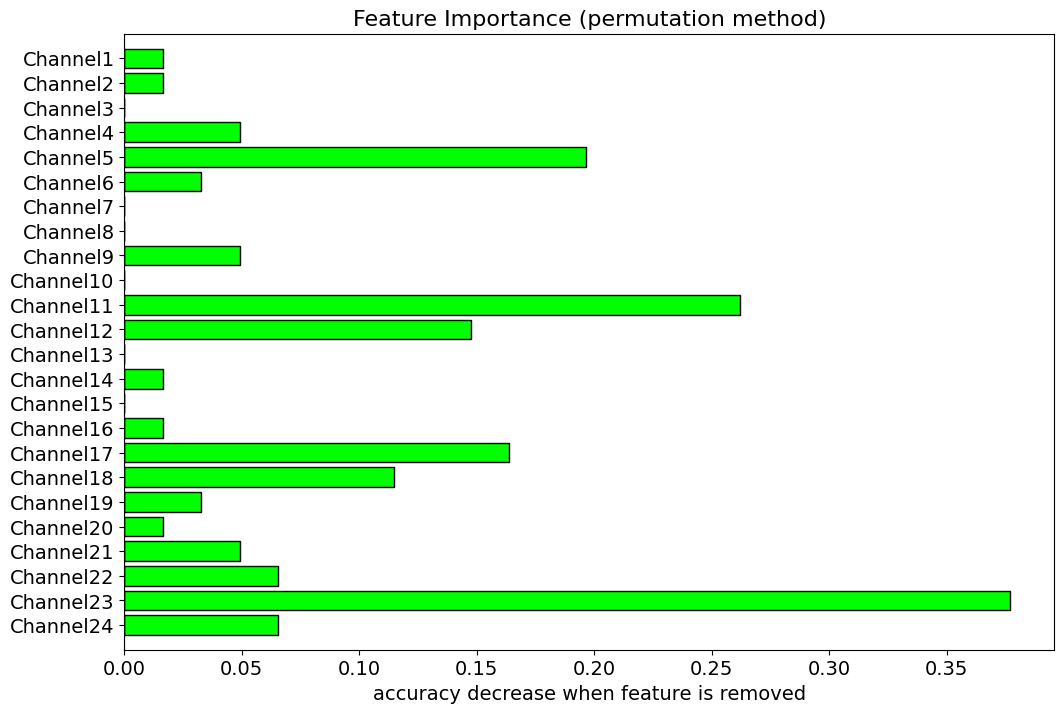

Feature importance df saved to data/Resultate_WichtigeMerkmale/NATOPS_FI_XCM_Klassen.csv


,Feature,accuracy,accuracy_change
0,Channel23,0.622951,0.377049
1,Channel11,0.737705,0.262295
2,Channel5,0.803279,0.196721
3,Channel17,0.836066,0.163934
4,Channel12,0.852459,0.147541
5,Channel18,0.885246,0.114754
6,Channel22,0.934426,0.065574
7,Channel24,0.934426,0.065574
8,Channel4,0.950820,0.049180
9,Channel9,0.950820,0.049180


In [ ]:
learn_XCM.feature_importance(X=input_values.detach().cpu().numpy(), y=dls.decodes(labels),
                             feature_names=arr, sel_classes= [ klassen_namen[1], klassen_namen[2]],
                             save_df_path='data/Resultate_WichtigeMerkmale/'+dsid+'_FI_XCM_Klassen',
                             figsize=(12,8))

X.shape: (61, 24, 51)
y.shape: (61,)
Selected metric: accuracy
Computing step importance...


  0 step: BASELINE             accuracy: 1.000000


  1 step: 0 to 0               accuracy: 1.000000


  2 step: 1 to 5               accuracy: 0.983607


  3 step: 6 to 10              accuracy: 0.950820


  4 step: 11 to 15             accuracy: 0.918033


  5 step: 16 to 20             accuracy: 0.770492


  6 step: 21 to 25             accuracy: 0.836066


  7 step: 26 to 30             accuracy: 0.836066


  8 step: 31 to 35             accuracy: 0.885246


  9 step: 36 to 40             accuracy: 0.950820


 10 step: 41 to 45             accuracy: 0.934426


 11 step: 46 to 50             accuracy: 0.918033



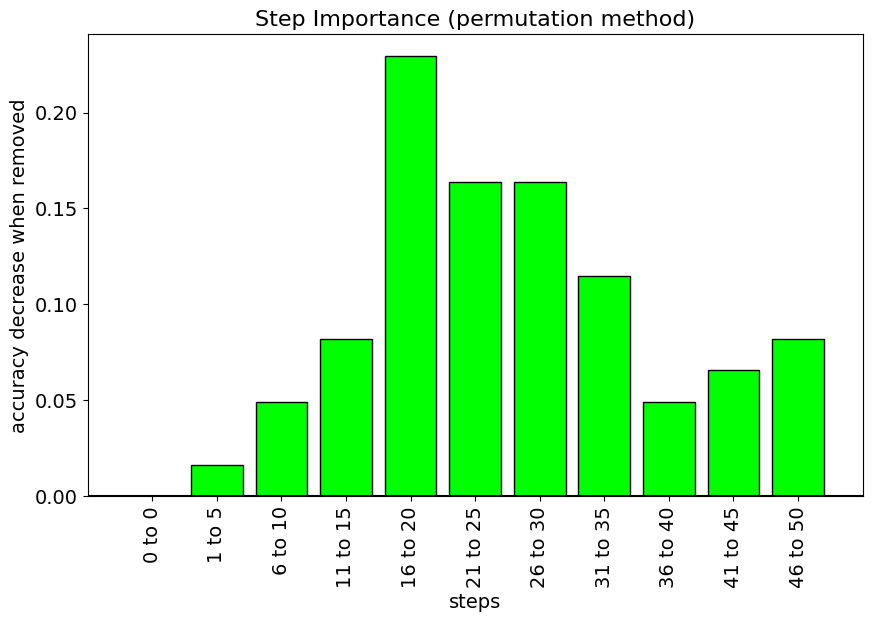

Step importance df saved to data/Resultate_WichtigeMerkmale/NATOPS_StepFI_XCM_Klassen.csv


,Step,accuracy,accuracy_change
0,16 to 20,0.770492,0.229508
1,21 to 25,0.836066,0.163934
2,26 to 30,0.836066,0.163934
3,31 to 35,0.885246,0.114754
4,11 to 15,0.918033,0.081967
5,46 to 50,0.918033,0.081967
6,41 to 45,0.934426,0.065574
7,6 to 10,0.950820,0.049180
8,36 to 40,0.950820,0.049180
9,1 to 5,0.983607,0.016393


In [ ]:
learn_XCM.step_importance(X=input_values.detach().cpu().numpy(),y=dls.decodes(labels),
                          sel_classes= [klassen_namen[1], klassen_namen[2]],
                          n_steps = 5, save_df_path='data/Resultate_WichtigeMerkmale/'+dsid+'_StepFI_XCM_Klassen'
                          , figsize = (10,6))


# XAI: GradCam of XCM Model

                                                     The grad-cam of datainstance: 176                                                      
                                                    Wrong prediction: 3|| True Class: 2                                                     


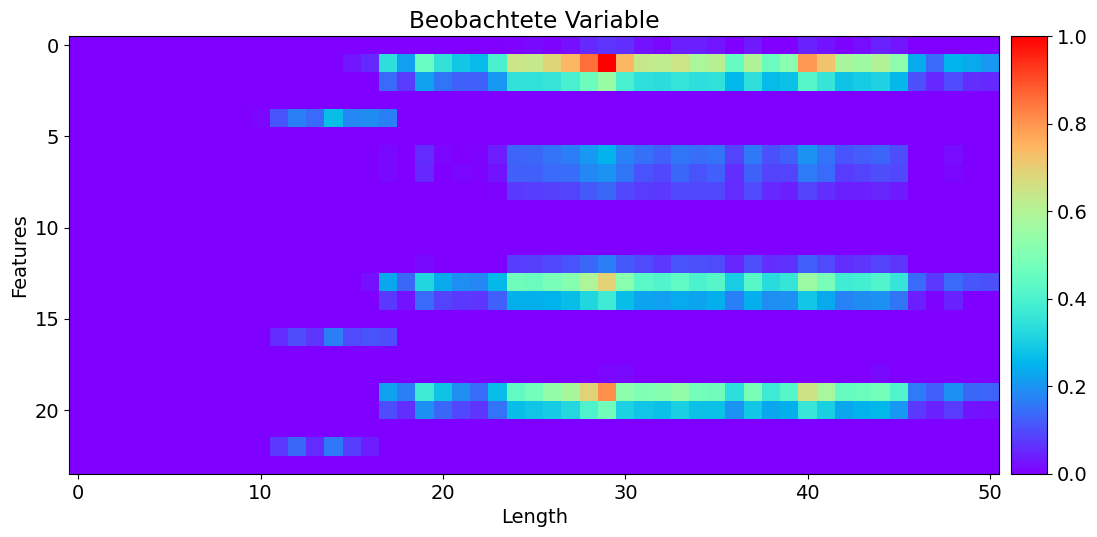

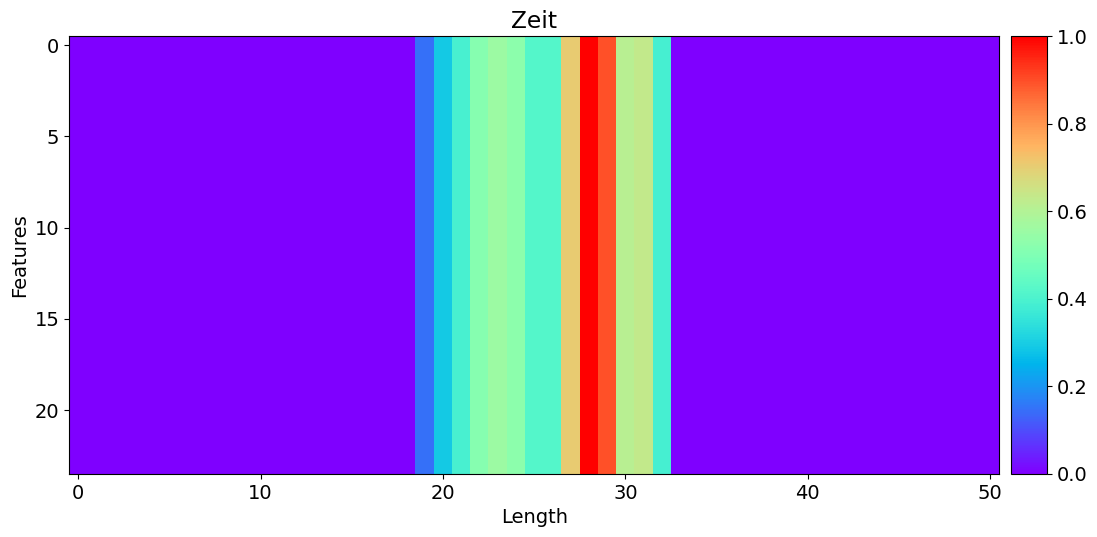

In [ ]:
datainstance = list_of_miss_predicted[8]
wrong_class = list_of_wrong_classes[8]
true_class = list_of_true_classes[8]

text_grad = "The grad-cam of datainstance: " + str(datainstance)
text_pred_true = "Wrong prediction: " + str(wrong_class) + "|| True Class: " + str(true_class)
print(text_grad.center(140))
print(text_pred_true.center(140))
learn_XCM.show_gradcam(x = input_values[datainstance], figsize = (12,8))



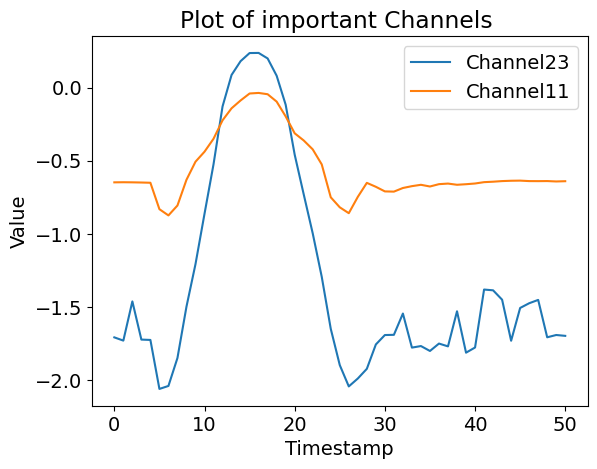

In [ ]:
feature_number_1 = 22
feature_number_2 = 10
input_values_datainstance = input_values[datainstance]

# Convert TSTensor in Tensor
tensor = TSTensor(input_values_datainstance)

# Extraction of channel
channel_1 = tensor[feature_number_1]
channel_2 = tensor[feature_number_2]

# Convert Tensor in NumPy-Array
channel_np_1 = channel_1.cpu().numpy()
channel_np_2 = channel_2.cpu().numpy()

# Plot of channels
plt.plot(channel_np_1, label = "Channel" + str(feature_number_1 + 1))
plt.plot(channel_np_2, label = "Channel" + str(feature_number_2 + 1))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot of important Channels ')
plt.legend()
plt.show()

Aber die richtige Instanze ist : 
3


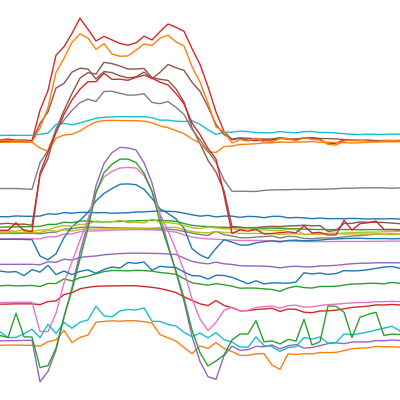

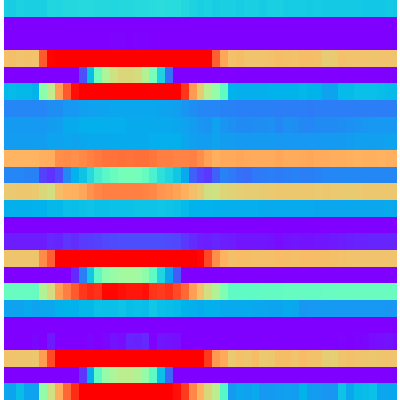

torch.Size([1, 3, 400, 400])


In [ ]:
print("Correct class is : ")
print(labels[datainstance].item() + 1)
out = TSToPlot(size=400)(input_values[datainstance], split_idx=0)
out[0].show()
out = TSToMat(cmap="rainbow", size=400)(input_values[datainstance], split_idx=0)
out[0].show()
print(out.shape)

# References:


* [1] H. Ismail Fawaz, G. Forestier, J. Weber, L. Idoumghar, and P.-A. Muller, “Deep     learning for time series classification: a review,” Data Mining and Knowledge Discovery, vol. 33, no. 4, pp. 917–963, 2019.
* [2] http://www.timeseriesclassification.com/description.php?Dataset=NATOPS
* [3] K. Fauvel, T. Lin, V. Masson, É. Fromont, and A. Termier, “Xcm: An explainable convolutional neural network for multivariate time series classification,” Mathematics, vol. 9, no. 23, p. 3137, 2021.
* [4] https://github.com/timeseriesAI/tsai
* [5] https://github.com/fastai/fastai
* [6] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 618-626, doi: 10.1109/ICCV.2017.74.
* [7] Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. “All models are wrong, but many are useful: Learning a variable’s importance by studying an entire class of prediction models simultaneously.” http://arxiv.org/abs/1801.01489 (2018)
